<a href="https://colab.research.google.com/github/malcolmlett/robovac/blob/main/Experiment_Generate_LDS_Training_Data_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Experiment: Generate LDS Training Data (v1)
For our very first initial network, we create a very simple UNet that attempts to reconstruct the ground-truth occupancy-map from an LDS-generated occupancy-map.

For that, we'll need to generate training data.

We'll start with our single low-res simple floorplan and prove that we can create a bunch of samples from it.

In [2]:
import os
if os.path.isdir('repo'):
  # discard any local changes and update
  !cd repo && git reset --hard HEAD
  !cd repo && git fetch
else:
  !git clone https://github.com/malcolmlett/robovac.git repo

# lock to revision
!cd repo && git checkout afbab9b

from repo import lds
from importlib import reload
reload(lds)

Cloning into 'repo'...
remote: Enumerating objects: 118, done.
remote: Counting objects: 100% (118/118), done.
remote: Compressing objects: 100% (95/95), done.
remote: Total 118 (delta 49), reused 64 (delta 17), pack-reused 0 (from 0)
Receiving objects: 100% (118/118), 4.74 MiB | 18.17 MiB/s, done.
Resolving deltas: 100% (49/49), done.
Note: switching to 'afbab9b'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by switching back to a branch.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -c with the switch command. Example:

  git switch -c <new-branch-name>

Or undo this operation with:

  git switch -

Turn off this advice by setting config variable advice.detachedHead to false

HEAD is now at afbab9b Merge remote-tracking branch 'refs/remotes/origin/main'


<module 'repo.lds' from '/content/repo/lds.py'>

In [3]:
!pip install -Uqq ipdb

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 20.8 MB/s eta 0:00:00


In [47]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from PIL import Image
import io
import cv2
import requests
import math
import ipdb
from timeit import default_timer as timer
import tqdm

In [5]:
# Load our simple low-res black'n'white floorplan
floorplan = Image.open('repo/data/experimental-floorplan1.png')
floorplan = np.array(floorplan, dtype=bool)
print(f"floorplan: shape={floorplan.shape}, dtype={floorplan.dtype}")

floorplan: shape=(84, 94), dtype=bool


## Training data generation
We'll create training data by generating a bunch of samples from the floorplan.

For each attempted sample:
1. pick a random location and orientation on the map
1. take a sample
1. discard if the ranges all end up within the radius of a single pixel (ie: our random chosen location was inside a wall)
1. generate a zeroed-out max_distance x max_distance semantic map, centered on the chosen location
1. populate a True/1 into the nearest-neighbour pixel corresponding to each LDS hit.
1. that becomes the training X data
1. separately, take a max_distance x max_distance square snapshot of the floorplan, centred on the chosen location.
1. apply a mask that zeros-out the corners - anything beyond the max_distance radius from the centre
1. that becomes the training Y labels


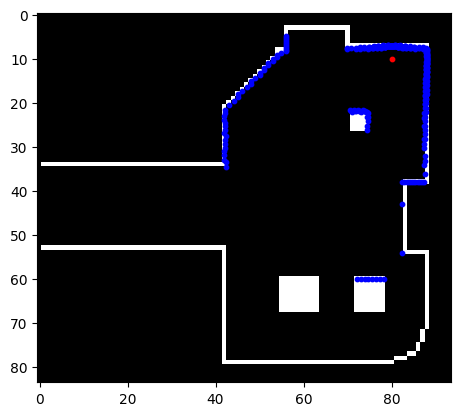

In [6]:
pixel_size = 6.8  # cm
max_distance = 350 # cm
loc = np.array([80.0, 10.0]) * pixel_size
#loc = (80, 10)
ranges = lds.lds_sample(floorplan, loc, 0.0, pixel_size=pixel_size, max_distance=max_distance)
points = lds.lds_to_2d(ranges, loc, 0.0)
plt.imshow(floorplan, cmap='gray')
plt.scatter(loc[0]/pixel_size, loc[1]/pixel_size, c='r', s=10)
plt.scatter(points[:,0]/pixel_size, points[:,1]/pixel_size, c='b', s=10)

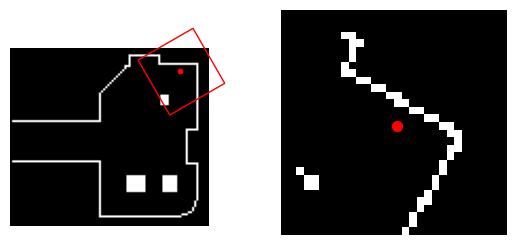

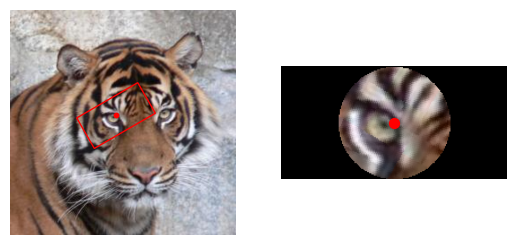

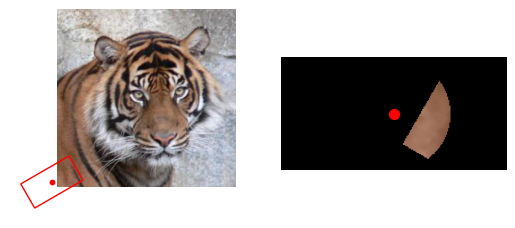

In [7]:
# Considerations:
# - Usually operating with a large crop that spans much of the original image.
# Algorithm:
# - Rotates the full image in the opposite direction,
#   with some extra padding so we don't loose anything
# - Then takes a simple rectangular crop
# - But does have to deal with clipping at the edges
def rotated_crop(image, centre, angle, size, **kwargs):
  """
  Takes a crop of a particular size and angle from any image-like source.
  Fills in any unknown areas with zeros.

  Arguments:
  - image: array (r,c) of bool, uint8, float32, etc.
      The image to take a crop from.
  - centre: [x,y] of float
      Centre of the crop, with sub-pixel precision.
      May be outside of the image bounds.
  - angle: float
      The angle of the crop in radians, counterclockwise.
  - size: [w,h] of int
      The size of the crop.

  Keyword Args:
  - mask: str (optional), default: 'none
      The mask to apply after cropping, zeroing out anything
      that isn't accepted by the mask.
      Mask is one of:
        - 'none' - do mask
        - 'inner-circle' - retains only the inner circle
  """
  # config
  mask = kwargs.get('mask', 'none')

  # handle boolean image types
  target_type = image.dtype
  if target_type == 'bool':
    image = image.astype(np.uint8)

  # pad original image so we don't loose things when we rotate it
  image_radius = np.linalg.norm(image.shape[0:2])/2
  pad_size_x = int(np.ceil(image_radius - image.shape[1]/2))
  pad_size_y = int(np.ceil(image_radius - image.shape[0]/2))
  image = cv2.copyMakeBorder(image, pad_size_y, pad_size_y, pad_size_x, pad_size_y, cv2.BORDER_CONSTANT, value=0)

  h, w = image.shape[0:2]
  centre = (centre[0] + pad_size_x, centre[1] + pad_size_y)

  # rotate whole image about the centre point
  rotation_matrix = cv2.getRotationMatrix2D(centre, -np.rad2deg(angle), scale=1.0)
  rotated = cv2.warpAffine(image, rotation_matrix, (w,h), flags=cv2.INTER_NEAREST)

  # take crop around the centre point
  # (here we have to convert from sub-pixel resolution to pixels,
  #  we take the mathematical floor on the left/top edge of the crop.
  #  It's important to note that this places our target centre slightly biased
  #  towards the bottom/right edge of the crop)
  crop_shape = np.array(image.shape)
  crop_shape[0] = size[1]
  crop_shape[1] = size[0]
  cropped = np.full(crop_shape, 0, dtype=image.dtype)

  # the following has been tested on 3x3 and 4x4 sizes
  x1 = max(0, int(centre[0] - (size[0]-1)/2))
  x2 = min(w, int(centre[0] - (size[0]-1)/2) + size[0])
  y1 = max(0, int(centre[1] - (size[1]-1)/2))
  y2 = min(h, int(centre[1] - (size[1]-1)/2) + size[1])

  start_x = max(0, -int(centre[0] - (size[0]-1)/2))
  start_y = max(0, -int(centre[1] - (size[1]-1)/2))
  cropped[start_y:start_y + (y2-y1), start_x:start_x + (x2-x1), ...] = rotated[y1:y2, x1:x2, ...]

  # apply mask
  if mask == 'none':
    pass
  elif mask == 'inner-circle':
    # the following has been tested on 3x3 and 4x4 sizes
    crop_cntr_x = cropped.shape[1]
    crop_radius = (np.min(size)-1)/2
    y,x = np.ogrid[:size[1], :size[0]]
    mask = ((x-int(size[0]/2))**2 + (y-int(size[1]/2))**2) <= crop_radius**2
    # broadcasting doesn't cope for some reason so manually expand mask if needed
    if cropped.ndim == 3:
      mask = mask[:, :, np.newaxis]
    cropped = cropped * mask
  else:
    raise ValueError(f"Unknown mask type: {mask}")

  # convert back to target type
  if target_type == 'bool':
    cropped = cropped.astype(bool)

  return cropped

def rotated_crop_test(image, loc, size, angle, **kwargs):
  crop = rotated_crop(image, loc, np.deg2rad(angle), size, **kwargs)

  plt.subplot(1,2,1)
  plt.imshow(image, cmap='gray')
  plt.scatter(loc[0], loc[1], c='r', s=10)
  plt.gca().add_patch(plt.Rectangle((loc[0]-(size[0]-1)/2,loc[1]-(size[1]-1)/2), size[0], size[1], angle=-angle, rotation_point='center', linewidth=1, edgecolor='r', facecolor='none'))
  plt.axis('off')

  plt.subplot(1,2,2)
  plt.imshow(crop, cmap='gray')
  plt.scatter(int(crop.shape[1]/2), int(crop.shape[0]/2), c='r', s=50)
  plt.axis('off')
  plt.show()

tiger = cv2.imread('repo/misc/images/640px-Tiger.50.jpg')
tiger = cv2.cvtColor(tiger, cv2.COLOR_BGR2RGB)

rotated_crop_test(floorplan, loc=(80.0,10.0), size=(30,30), angle=30, mask='inner-circle')
#rotated_crop_test(floorplan, loc=(87.0,8.0), size=(8,8), angle=0, mask='inner-circle')
#rotated_crop_test(floorplan, loc=(80.5,10.5), size=(30,30), angle=30)
#rotated_crop_test(floorplan, loc=(81.0,11.0), size=(30,30), angle=30)
rotated_crop_test(tiger, loc=(300,300), size=(200,100), angle=30, mask='inner-circle')
rotated_crop_test(tiger, loc=(-20,620), size=(200,100), angle=30, mask='inner-circle')


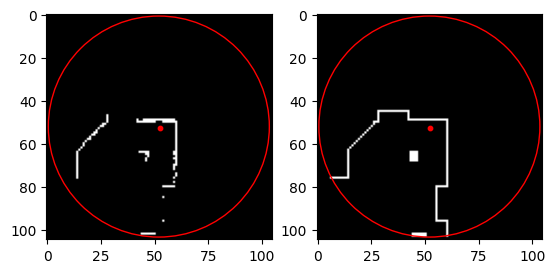

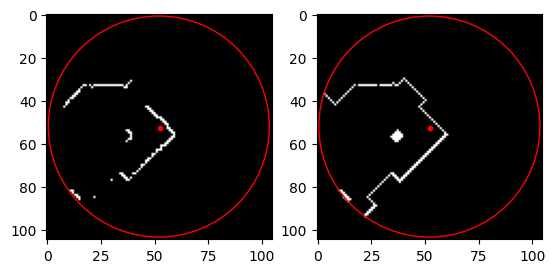

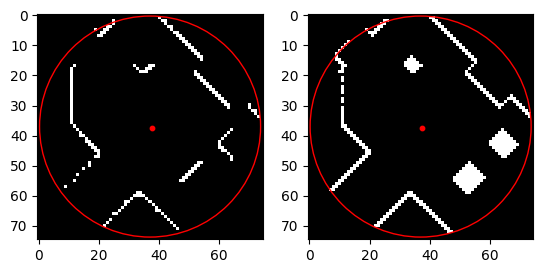

Empty sample


In [21]:
def generate_training_data_sample(semantic_map, centre, angle, **kwargs):
    """
    Generates a single training sample from the semantic map.
    Returns (None,None) if the sample is meaningless, which can occur when
    the specified centere is within the bounds of the pixels (all LDS ranges have value ~0.0),
    or if there are no LDS hits (all LDS ranges are NaN).

    Parameters:
    - semantic_map: array (r,c) of bool or float
        Encoded as a 2D array of values.
    - centre: [x,y] of float
        Point from which LDS sample is taken (unit: physical units)
    - angle: float
        Starting angle of LDS sample (unit: radians)

    Keyword args:
    - max_distance: float, default: 100
        Maximum distance that an LDS can observe (unit: physical units)
    - pixel_size: float, default: 1.0.
        The size of the pixel in the desired physical unit.
        Defaults to 1.0, meaning that we output in pixel units.
    - nothing_value: bool or float, default: min value from semantic_map
        The data value that indicates nothing is present at the pixel.
        All other values are treated as pixels.
    - occupated_value: bool or float, default: max value from semantic_map
        The data value used by LDS hits.

    Returns:
    (lds_map, ground_truth_map), where:
      - lds_map: array (r,c) of bool or flat
          Square max_distance x max_distance semantic map populated from LDS data alone.
      - ground_truth_map: array (r,c) of bool or flat
          Square max_distance x max_distance masked snapshot from ground truth source semantic map.
    """
    # config
    max_distance = kwargs.get('max_distance', 100)
    pixel_size = kwargs.get('pixel_size', 1.0)
    nothing_value = kwargs.get('nothing_value', np.min(semantic_map))
    occupated_value = kwargs.get('occupated_value', np.max(semantic_map))
    #print(f"values: nothing={nothing_value}, occupated={occupated_value}")

    # take sample
    ranges = lds.lds_sample(semantic_map, centre, angle, max_distance=max_distance, pixel_size=pixel_size, nothing_value=nothing_value)
    if (np.nanmax(ranges) < pixel_size) or ranges[~np.isnan(ranges)].size == 0:
        return None, None
    #print(f"ranges: {np.nanmin(ranges)}-{np.nanmax(ranges)}")

    # generate LDS semantic map
    # (note: from LDS data alone we don't know absolute centre or orientation, so we work relative to origin here)
    lds_points = lds.lds_to_2d(ranges, (0,0), 0.0)
    #print(lds_points.astype(str))
    size_px = np.ceil(max_distance / pixel_size).astype(int) * 2 + 1  # odd numbered, with equivalent of max_distance out from centre pixel
    lds_points_px = np.round(lds_points / pixel_size + (size_px-1)/2).astype(int)
    #print(f"semantic_map: {semantic_map.shape}, lds_points: {lds_points.shape}, size_px: {size_px}")
    #print(f"points(lds.rel): ({np.min(lds_points[:,0])},{np.min(lds_points[:,1])})-({np.max(lds_points[:,0])},{np.max(lds_points[:,1])})")
    #print(f"points(px.abs): ({np.min(lds_points_px[:,0])},{np.min(lds_points_px[:,1])})-({np.max(lds_points_px[:,0])},{np.max(lds_points_px[:,1])})")
    lds_map = np.full((size_px, size_px), nothing_value, dtype=semantic_map.dtype)
    lds_map[lds_points_px[:,1], lds_points_px[:,0]] = occupated_value

    # generate ground truth map
    # (here we know the centre and orientation, but we have to translate it to the same location and orientation as used by the LDS map)
    centre_px = centre / pixel_size  # sub-pixel resolution
    ground_truth_map = rotated_crop(semantic_map, centre_px, angle, size=(size_px, size_px), mask='inner-circle')

    return (lds_map, ground_truth_map)

def generate_training_data_sample_test(floorplan, loc_px, degrees, max_distance):
  pixel_size=6.8
  loc = np.array(loc_px) * pixel_size
  angle = np.deg2rad(degrees)
  (lds_map, truth_map) = generate_training_data_sample(floorplan, loc, angle, max_distance=max_distance, pixel_size=pixel_size)

  if lds_map is None:
    print("Empty sample")
    return

  centre_px = int(truth_map.shape[1]/2), int(truth_map.shape[0]/2)

  plt.subplot(1,2,1)
  plt.imshow(lds_map, cmap='gray')
  plt.scatter(lds_map.shape[0]/2, lds_map.shape[1]/2, c='r', s=10)
  plt.gca().add_patch(plt.Circle(centre_px, radius=max_distance/pixel_size, linewidth=1, edgecolor='r', facecolor='none'))

  plt.subplot(1,2,2)
  plt.imshow(truth_map, cmap='gray')
  plt.scatter(lds_map.shape[0]/2, lds_map.shape[1]/2, c='r', s=10)
  plt.gca().add_patch(plt.Circle(centre_px, radius=max_distance/pixel_size, linewidth=1, edgecolor='r', facecolor='none'))
  plt.show()

generate_training_data_sample_test(floorplan, (80.0, 10.0), 0, 350)
generate_training_data_sample_test(floorplan, (80.0, 10.0), 45, 350)
generate_training_data_sample_test(floorplan, (60.0, 40.0), -45, 250)
generate_training_data_sample_test(floorplan, (73.0, 22.0), 0, 250)

x,y = [126.80249933 556.57209011], angle=-1.8427378940485346
x,y = [524.71055061 312.19243188], angle=0.7021073975573935
x,y = [437.48656762 331.37277785], angle=-1.2767401029225438
x,y = [107.22636581  51.60981899], angle=1.498164565716917
x,y = [252.07582812 101.19166744], angle=2.387214772097307
X: 5 x (105, 105)
Y: 5 x (105, 105)


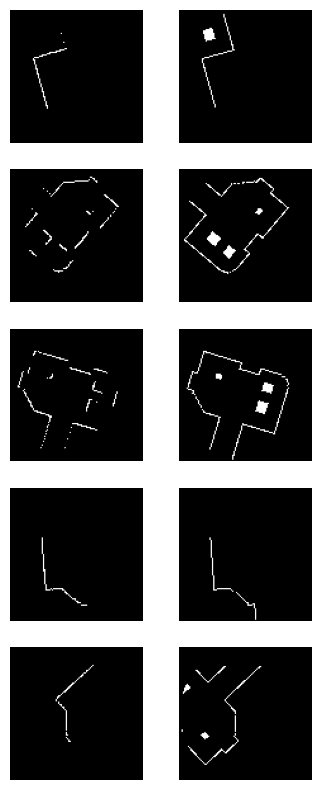

In [11]:
def generate_training_data(semantic_map, num_samples, **kwargs):
    """
    Generates training data sampled from the semantic map.

    Keyword args:
    - max_distance: float, default: 100
        Maximum distance that an LDS can observe (unit: physical units)
    - pixel_size: float, default: 1.0.
        The size of the pixel in the desired physical unit.
        Defaults to 1.0, meaning that we output in pixel units.
    - nothing_value: bool or float, default: min value from semantic_map
        The data value that indicates nothing is present at the pixel.
        All other values are treated as pixels.
    - occupated_value: bool or float, default: max value from semantic_map
        The data value used by LDS hits.

    Returns:
    Each training data X item contains:
    - 2d-array (r,c) raw semantic_map from LDS data alone
    Each training data Y item contains:
    - 2d-array (r,c) expected semantic_map
    """
    pixel_size = kwargs.get('pixel_size', 1.0)

    X = []
    Y = []
    while len(X) < num_samples:
      loc = np.random.uniform((0,0), semantic_map.shape) * pixel_size
      angle = np.random.uniform(-np.pi, np.pi)

      print(f"x,y = {loc}, angle={angle}")
      (lds_map, truth_map) = generate_training_data_sample(floorplan, loc, angle, **kwargs)
      if lds_map is not None:
        X.append(lds_map)
        Y.append(truth_map)

    return (X, Y)

def generate_training_data_test():
  np.random.seed(5)
  X, Y = generate_training_data(floorplan, 5, pixel_size=6.8, max_distance=350)
  print(f"X: {len(X)} x {X[0].shape}")
  print(f"Y: {len(Y)} x {Y[0].shape}")

  plt.figure(figsize=(4, 10))
  for i in range(0,5):
    plt.subplot(5,2,i*2+1)
    plt.imshow(X[i], cmap='gray')
    plt.axis('off')

    plt.subplot(5,2,i*2+2)
    plt.imshow(Y[i], cmap='gray')
    plt.axis('off')
  plt.show()

generate_training_data_test()

## Learnings
* The ground-truths are not very realistic as they include too much knowledge that the LDS data doesn't provide.
* I also want to get different labels: black=unknown, grey=floor, white=wall.
* If I train a NN against this training data it's going to produce a lot of occupancy data in areas that it can't actually see, because I'm training it to guess. That might get messy once I start combining multiple iterations of LDS data into an overal map. On the other hand, perhaps the network will be able to cope by representing a level of uncertainty in its outputs.

## Bug: Unexpected Clipping
In later work I found that some ground-truth images are getting clipped in a way that doesn't look right.

Exampe:
* x,y = [458.84427354 575.83407481], angle=-2.4779960361221005


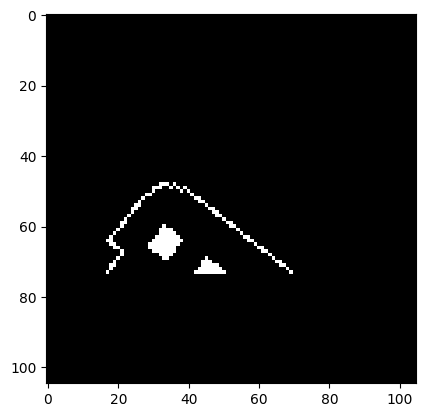

In [16]:
loc = np.array([458.84427354, 575.83407481])
angle=-2.4779960361221005
(lds_map, truth_map) = generate_training_data_sample(floorplan, loc, angle, pixel_size=6.8, max_distance=350)
plt.imshow(truth_map, cmap='gray')

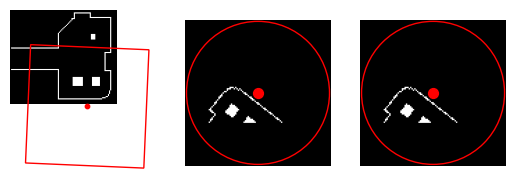

In [32]:
pixel_size = 6.8
max_distance = 350
angle=-2.4779960361221005
loc = np.array([458.84427354, 575.83407481]) / pixel_size
size = np.array([105, 105])
crop = rotated_crop(floorplan, loc, angle, size=size, mask='none')
crop_masked = rotated_crop(floorplan, loc, angle, size=size, mask='inner-circle')

#plt.imshow(truth_map, cmap='gray')

plt.subplot(1,3,1)
plt.imshow(floorplan, cmap='gray')
plt.scatter(loc[0], loc[1], c='r', s=10)
plt.gca().add_patch(plt.Rectangle((loc[0]-(size[0]-1)/2,loc[1]-(size[1]-1)/2), size[0], size[1], angle=-angle, rotation_point='center', linewidth=1, edgecolor='r', facecolor='none'))
plt.axis('off')

plt.subplot(1,3,2)
plt.imshow(crop, cmap='gray')
plt.scatter(int(crop.shape[1]/2), int(crop.shape[0]/2), c='r', s=50)
plt.gca().add_patch(plt.Circle((int(crop.shape[1]/2), int(crop.shape[0]/2)), radius=max_distance/pixel_size, linewidth=1, edgecolor='r', facecolor='none'))
plt.axis('off')

plt.subplot(1,3,3)
plt.imshow(crop_masked, cmap='gray')
plt.scatter(int(crop.shape[1]/2), int(crop.shape[0]/2), c='r', s=50)
plt.gca().add_patch(plt.Circle((int(crop.shape[1]/2), int(crop.shape[0]/2)), radius=max_distance/pixel_size, linewidth=1, edgecolor='r', facecolor='none'))
plt.axis('off')
plt.show()


original: (84, 94), padded: (137, 120), rotated: (137, 120), crop: (105, 105), maksed: (105, 105)


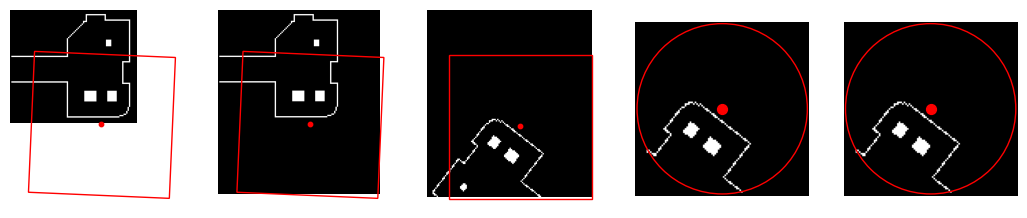

In [50]:
def rotated_crop2(image, centre, angle, size, **kwargs):
  """
  Takes a crop of a particular size and angle from any image-like source.
  Fills in any unknown areas with zeros.

  This function operates against pixels and knows nothing of physical units.

  Arguments:
  - image: array (r,c) of bool, uint8, float32, etc.
      The image to take a crop from.
  - centre: [x,y] of float, unit: pixels.
      Centre of the crop, with sub-pixel precision.
      May be outside of the image bounds.
  - angle: float
      The angle of the crop in radians, counterclockwise.
  - size: [w,h] of int, unit: pixels
      The size of the crop.

  Keyword Args:
  - mask: str (optional), default: 'none
      The mask to apply after cropping, zeroing out anything
      that isn't accepted by the mask.
      Mask is one of:
        - 'none' - do mask
        - 'inner-circle' - retains only the inner circle
  """
  # config
  mask = kwargs.get('mask', 'none')

  # handle boolean image types
  target_type = image.dtype
  if target_type == 'bool':
    image = image.astype(np.uint8)

  # pad original image so we don't loose things when we rotate it
  # The amount of pad required differs by:
  #   - image size
  #       - roughly, adding an extra sqrt(1/2)*image_width to cope with the image
  #         being rotated about centre without loosing its corners.
  #   - crop location and size
  #       - if we're rotating about a point on the edge of the image, then we
  #         want room available in the target location for the crop
  # I think it's sufficient to just cope with the latter. So we overlay
  # the crop template over the un-rotated source image, and expand the source image
  # to fit into the crop location.

  # eventual crop window without clipping:
  x1 = int(centre[0] - (size[0]-1)/2)
  x2 = int(centre[0] - (size[0]-1)/2) + size[0]
  y1 = int(centre[1] - (size[1]-1)/2)
  y2 = int(centre[1] - (size[1]-1)/2) + size[1]

  pad_x1 = max(0, -x1)
  pad_x2 = max(0, x2 - image.shape[1])
  pad_y1 = max(0, -y1)
  pad_y2 = max(0, y2 - image.shape[0])
  if max(pad_x1, pad_x2, pad_y1, pad_y2) > 0:
    #print(f"pad: {pad_x1},{pad_x2},{pad_y1},{pad_y2}")
    image = cv2.copyMakeBorder(image, pad_y1, pad_y2, pad_x1, pad_x2, cv2.BORDER_CONSTANT, value=0)

  h, w = image.shape[0:2]
  centre = (centre[0] + pad_x1, centre[1] + pad_y1)

  # rotate whole image about the centre point
  rotation_matrix = cv2.getRotationMatrix2D(centre, -np.rad2deg(angle), scale=1.0)
  rotated = cv2.warpAffine(image, rotation_matrix, (w,h), flags=cv2.INTER_NEAREST)

  # take crop around the centre point
  # (here we have to convert from sub-pixel resolution to pixels,
  #  we take the mathematical floor on the left/top edge of the crop.
  #  It's important to note that this places our target centre slightly biased
  #  towards the bottom/right edge of the crop)
  #crop_shape = np.array(image.shape)
  #crop_shape[0] = size[1]
  #crop_shape[1] = size[0]
  #cropped = np.full(crop_shape, 0, dtype=image.dtype)

  # the following has been tested on 3x3 and 4x4 sizes
  # (extra complexity not needed anymore)
  #x1 = max(0, int(centre[0] - (size[0]-1)/2))
  #x2 = min(w, int(centre[0] - (size[0]-1)/2) + size[0])
  #y1 = max(0, int(centre[1] - (size[1]-1)/2))
  #y2 = min(h, int(centre[1] - (size[1]-1)/2) + size[1])
  #
  #start_x = max(0, -int(centre[0] - (size[0]-1)/2))
  #start_y = max(0, -int(centre[1] - (size[1]-1)/2))
  #cropped[start_y:start_y + (y2-y1), start_x:start_x + (x2-x1), ...] = rotated[y1:y2, x1:x2, ...]
  #print(f"took crop: ({x2-x1},{y2-y1}), target size: {size}")

  # take crop around the centre point
  # (here we have to convert from sub-pixel resolution to pixels,
  #  we take the mathematical floor on the left/top edge of the crop.
  #  It's important to note that this places our target centre slightly biased
  #  towards the bottom/right edge of the crop)
  # (the following has been tested on 3x3 and 4x4 sizes)
  x1 = int(centre[0] - (size[0]-1)/2)
  x2 = int(centre[0] - (size[0]-1)/2) + size[0]
  y1 = int(centre[1] - (size[1]-1)/2)
  y2 = int(centre[1] - (size[1]-1)/2) + size[1]
  cropped = rotated[y1:y2, x1:x2, ...]

  # apply mask
  masked = cropped
  if mask == 'none':
    pass
  elif mask == 'inner-circle':
    # the following has been tested on 3x3 and 4x4 sizes
    crop_cntr_x = cropped.shape[1]
    crop_radius = (np.min(size)-1)/2
    y,x = np.ogrid[:size[1], :size[0]]
    mask = ((x-int(size[0]/2))**2 + (y-int(size[1]/2))**2) <= crop_radius**2
    # broadcasting doesn't cope for some reason so manually expand mask if needed
    if cropped.ndim == 3:
      mask = mask[:, :, np.newaxis]
    cropped = cropped * mask
  else:
    raise ValueError(f"Unknown mask type: {mask}")

  # convert back to target type
  if target_type == 'bool':
    masked = cropped.astype(bool)

  return image, rotated, cropped, masked

pixel_size = 6.8
max_distance = 350
angle=-2.4779960361221005
loc = np.array([458.84427354, 575.83407481]) / pixel_size
size = np.array([105, 105])
padded, rotated, crop, masked = rotated_crop2(floorplan, loc, angle, size=size, mask='inner-circle')
print(f"original: {floorplan.shape}, padded: {padded.shape}, rotated: {rotated.shape}, crop: {crop.shape}, maksed: {masked.shape}")

#plt.imshow(truth_map, cmap='gray')

plt.figure(figsize=(13, 15))
plt.subplot(1,5,1)
plt.imshow(floorplan, cmap='gray')
plt.scatter(loc[0], loc[1], c='r', s=10)
plt.gca().add_patch(plt.Rectangle((loc[0]-(size[0]-1)/2,loc[1]-(size[1]-1)/2), size[0], size[1], angle=-angle, rotation_point='center', linewidth=1, edgecolor='r', facecolor='none'))
plt.axis('off')

plt.subplot(1,5,2)
plt.imshow(padded, cmap='gray')
plt.scatter(loc[0], loc[1], c='r', s=10)
plt.gca().add_patch(plt.Rectangle((loc[0]-(size[0]-1)/2,loc[1]-(size[1]-1)/2), size[0], size[1], angle=-angle, rotation_point='center', linewidth=1, edgecolor='r', facecolor='none'))
plt.axis('off')

plt.subplot(1,5,3)
plt.imshow(rotated, cmap='gray')
plt.scatter(loc[0], loc[1], c='r', s=10)
plt.gca().add_patch(plt.Rectangle((loc[0]-(size[0]-1)/2,loc[1]-(size[1]-1)/2), size[0], size[1], angle=0, rotation_point='center', linewidth=1, edgecolor='r', facecolor='none'))
plt.axis('off')

plt.subplot(1,5,4)
plt.imshow(crop, cmap='gray')
plt.scatter(int(crop.shape[1]/2), int(crop.shape[0]/2), c='r', s=50)
plt.gca().add_patch(plt.Circle((int(crop.shape[1]/2), int(crop.shape[0]/2)), radius=max_distance/pixel_size, linewidth=1, edgecolor='r', facecolor='none'))
plt.axis('off')

plt.subplot(1,5,5)
plt.imshow(masked, cmap='gray')
plt.scatter(int(crop.shape[1]/2), int(crop.shape[0]/2), c='r', s=50)
plt.gca().add_patch(plt.Circle((int(crop.shape[1]/2), int(crop.shape[0]/2)), radius=max_distance/pixel_size, linewidth=1, edgecolor='r', facecolor='none'))
plt.axis('off')
plt.show()


pad: 16,0,0,36
original: (84, 94), padded: (120, 110), rotated: (120, 110), crop: (105, 105), maksed: (105, 105)


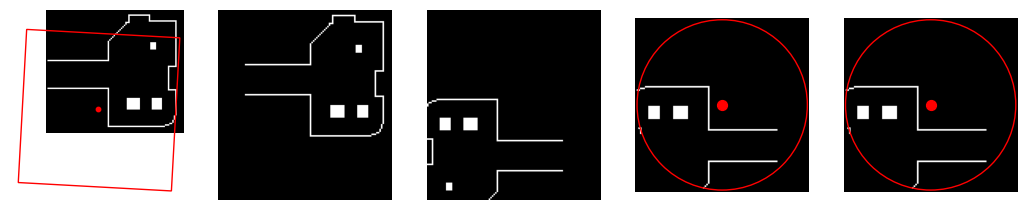

pad: 26,0,38,0
original: (84, 94), padded: (122, 120), rotated: (122, 120), crop: (105, 105), maksed: (105, 105)


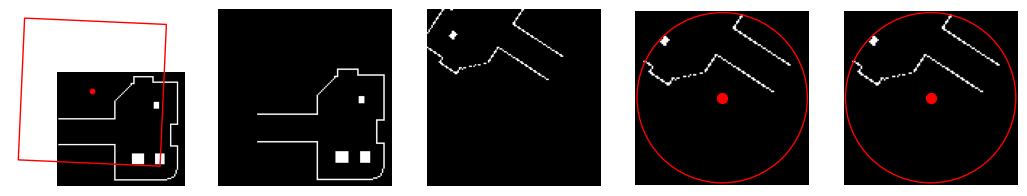

pad: 36,0,19,2
original: (84, 94), padded: (105, 130), rotated: (105, 130), crop: (105, 105), maksed: (105, 105)


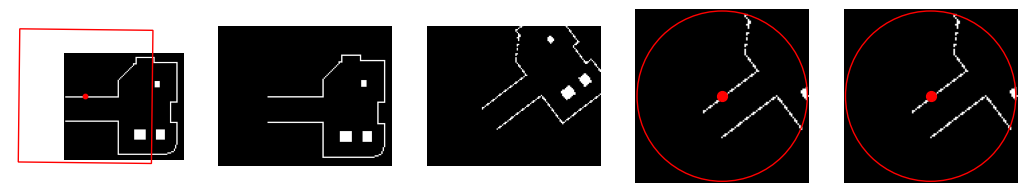

pad: 6,5,12,9
original: (84, 94), padded: (105, 105), rotated: (105, 105), crop: (105, 105), maksed: (105, 105)


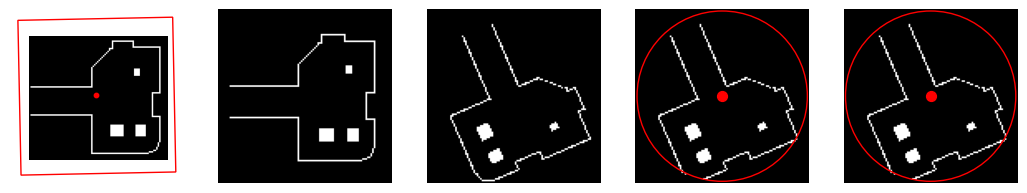

pad: 34,0,0,51
original: (84, 94), padded: (135, 128), rotated: (135, 128), crop: (105, 105), maksed: (105, 105)


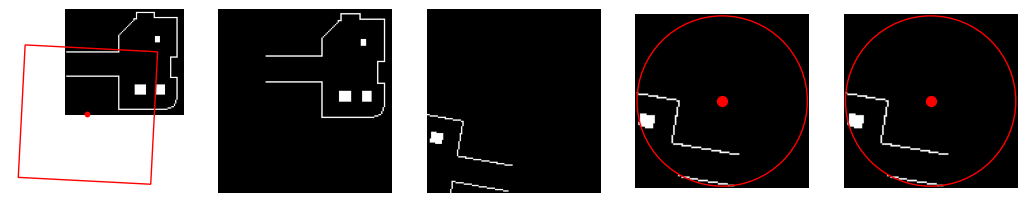

In [46]:
np.random.seed(1)
pixel_size = 6.8
max_distance = 350

for i in range(5):
  loc = np.random.uniform((0,0), floorplan.shape)
  angle = np.random.uniform(-np.pi, np.pi)
  size = np.array([105, 105])
  padded, rotated, crop, masked = rotated_crop2(floorplan, loc, angle, size=size, mask='inner-circle')
  print(f"original: {floorplan.shape}, padded: {padded.shape}, rotated: {rotated.shape}, crop: {crop.shape}, maksed: {masked.shape}")

  plt.figure(figsize=(13, 15))
  plt.subplot(1,5,1)
  plt.imshow(floorplan, cmap='gray')
  plt.scatter(loc[0], loc[1], c='r', s=10)
  plt.gca().add_patch(plt.Rectangle((loc[0]-(size[0]-1)/2,loc[1]-(size[1]-1)/2), size[0], size[1], angle=-angle, rotation_point='center', linewidth=1, edgecolor='r', facecolor='none'))
  plt.axis('off')

  plt.subplot(1,5,2)
  plt.imshow(padded, cmap='gray')
  plt.axis('off')

  plt.subplot(1,5,3)
  plt.imshow(rotated, cmap='gray')
  plt.axis('off')

  plt.subplot(1,5,4)
  plt.imshow(crop, cmap='gray')
  plt.scatter(int(crop.shape[1]/2), int(crop.shape[0]/2), c='r', s=50)
  plt.gca().add_patch(plt.Circle((int(crop.shape[1]/2), int(crop.shape[0]/2)), radius=max_distance/pixel_size, linewidth=1, edgecolor='r', facecolor='none'))
  plt.axis('off')

  plt.subplot(1,5,5)
  plt.imshow(masked, cmap='gray')
  plt.scatter(int(crop.shape[1]/2), int(crop.shape[0]/2), c='r', s=50)
  plt.gca().add_patch(plt.Circle((int(crop.shape[1]/2), int(crop.shape[0]/2)), radius=max_distance/pixel_size, linewidth=1, edgecolor='r', facecolor='none'))
  plt.axis('off')
  plt.show()

In [51]:
# And run a whole bunch to check that it doesn't error
np.random.seed(1)
pixel_size = 6.8
max_distance = 350

for i in tqdm.tqdm(range(1000)):
  loc = np.random.uniform((0,0), floorplan.shape)
  angle = np.random.uniform(-np.pi, np.pi)
  size = np.array([105, 105])
  rotated_crop2(floorplan, loc, angle, size=size, mask='inner-circle')

100%|██████████| 1000/1000 [00:00<00:00, 1186.39it/s]


There. This new padding approach is optimum for our needs and works well. yay!

## Appendix: OpenCV
In the above we needed to use OpenCV to work with images.
Here's some experiments.

image: (640, 640, 3), uint8


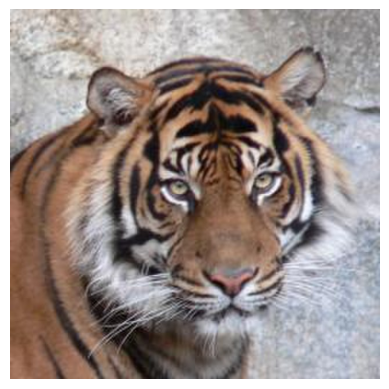

In [ ]:
# get image
image = cv2.imread('repo/misc/images/640px-Tiger.50.jpg')

print(f"image: {image.shape}, {image.dtype}")

# convert to RGB and show
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

rotation_matrix: [[  0.7878462    0.13891854 135.77843046]
 [ -0.13891854   0.7878462   88.90786697]]


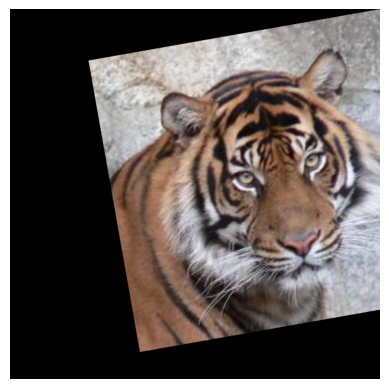

In [ ]:
rotation_matrix = cv2.getRotationMatrix2D((640,0), 10, scale=0.8)
print(f"rotation_matrix: {rotation_matrix}")
rotated = cv2.warpAffine(image, rotation_matrix, (640,640))

plt.imshow(cv2.cvtColor(rotated, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

rotation_matrix: [[   0.70710678    0.70710678 -444.26406871]
 [  -0.70710678    0.70710678  167.45166004]]


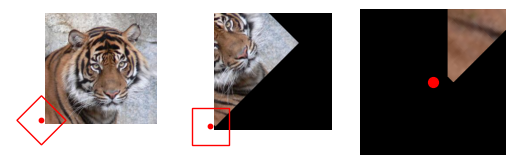

In [ ]:
def experimental_take_rotated_crop(image, centre, angle, size):
  h, w, _ = image.shape

  # rotate whole image first about the centre point
  rotation_matrix = cv2.getRotationMatrix2D(centre, angle, scale=1.0)
  print(f"rotation_matrix: {rotation_matrix}")
  rotated = cv2.warpAffine(image, rotation_matrix, (w,h), flags=cv2.INTER_NEAREST)

  # take crop around the centre point
  zero_value = True if image.dtype == 'bool' else 0 if np.issubdtype(image.dtype, np.integer) else 0.0
  crop_shape = np.array(image.shape)
  crop_shape[0] = size[1]
  crop_shape[1] = size[0]
  cropped = np.full(crop_shape, zero_value, dtype=image.dtype)

  x1 = max(0, int(centre[0] - size[0]/2))
  x2 = min(w, int(centre[0] - size[0]/2) + size[0])
  y1 = max(0, int(centre[1] - size[1]/2))
  y2 = min(h, int(centre[1] - size[1]/2) + size[1])

  start_x = max(0, -int(centre[0] - size[0]/2))
  start_y = max(0, -int(centre[1] - size[1]/2))
  cropped[start_y:start_y + (y2-y1), start_x:start_x + (x2-x1), :] = rotated[y1:y2, x1:x2, :]

  return (rotated,cropped)

loc = (-20,620)
size = (200,200)
angle = 45
(rotated, crop) = experimental_take_rotated_crop(image, loc, angle, size)

plt.subplot(1,3,1)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.scatter(loc[0], loc[1], c='r', s=10)
plt.gca().add_patch(plt.Rectangle((loc[0]-size[0]/2,loc[1]-size[1]/2), size[0], size[1], angle=angle, rotation_point='center', linewidth=1, edgecolor='r', facecolor='none'))
plt.axis('off')

plt.subplot(1,3,2)
plt.imshow(cv2.cvtColor(rotated, cv2.COLOR_BGR2RGB))
plt.scatter(loc[0], loc[1], c='r', s=10)
plt.gca().add_patch(plt.Rectangle((loc[0]-size[0]/2,loc[1]-size[1]/2), size[0], size[1], linewidth=1, edgecolor='r', facecolor='none'))
plt.axis('off')

plt.subplot(1,3,3)
plt.imshow(cv2.cvtColor(crop, cv2.COLOR_BGR2RGB))
plt.scatter(crop.shape[1]/2, crop.shape[0]/2, c='r', s=50)
plt.axis('off')
plt.show()